# CNN + Selective Search

## 载入套件

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import time
import cv2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

In [3]:
device = "cpu"

In [5]:
# 参数设定
WIDTH = 600              # 图像缩放为 (600, 600)
INPUT_SIZE = (224, 224)  # CNN的输入尺寸

## 载入 ResNet50 模型

In [6]:
model = models.resnet50(pretrained=True).to(device)

## 读取要辨识的图片

In [7]:
from PIL import Image

filename = './images_Object_Detection/bike.jpg'
orig = Image.open(filename)
# 等比例缩放图片
orig = orig.resize((WIDTH, int(orig.size[1] / orig.size[0] * WIDTH)))
Width_Height_ratio = orig.size[1] / orig.size[0]
orig.size

(600, 400)

## 定义转换函数

In [8]:
# 转换函数
transform = transforms.Compose([
    transforms.Resize(INPUT_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# PIL格式转换为OpenCV格式
def PIL2CV2(orig):
    pil_image = orig.copy()
    open_cv_image = np.array(pil_image) 
    return open_cv_image[:, :, ::-1].copy() 

## 以Selective Search取代滑动视窗及影像金字塔，取得每一个要侦测的视窗

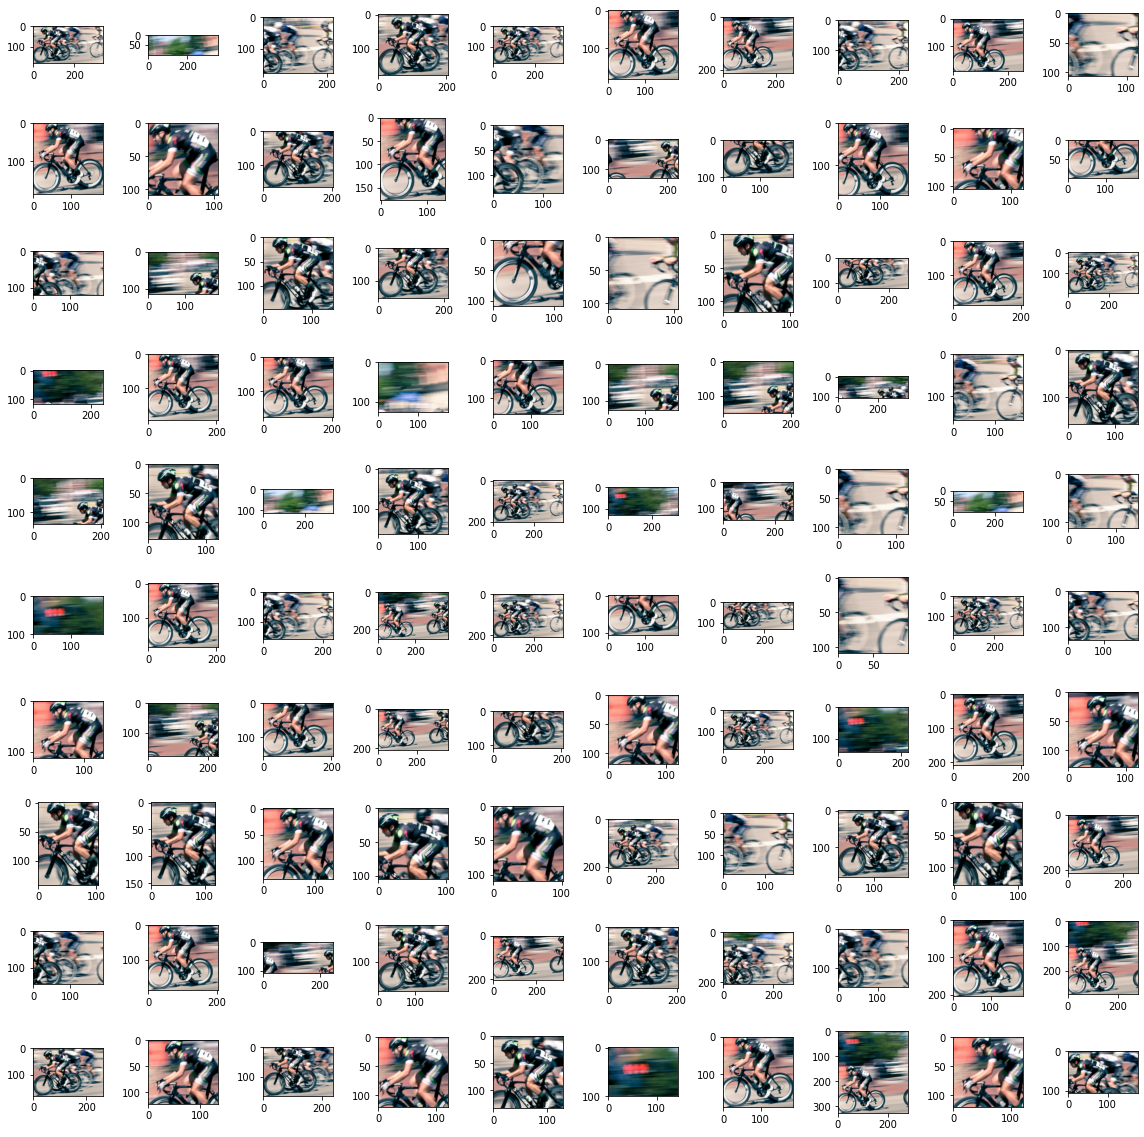

In [34]:
# 产生 Selective Search 影像
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))
def Selective_Search(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (WIDTH, int(orig.size[1] / orig.size[0] * WIDTH))
                     , interpolation=cv2.INTER_AREA)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    # 执行 Selective Search
    cv2.setUseOptimized(True)
    cv2.setNumThreads(8)
    gs = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    gs.setBaseImage(img)
    gs.switchToSelectiveSearchFast()
    rects = gs.process()
    # print(rects)
    
    rois = torch.tensor([])    # 候选框
    locs = []    # 位置
    j=1
    for i in range(len(rects)):
        x, y, w, h = rects[i]
        if w < 100 or w > 400 or h < 100: continue
            
        # 框与原图的比例
        scale = WIDTH / float(w)

        # 缩放图形以符合模型输入规格 
        crop_img = img[y:y+h, x:x+w]
        crop_img = Image.fromarray(crop_img)
        if j <= 100:
            plt.subplot(10, 10, j)
            plt.imshow(crop_img)
        j+=1
        
        roi = transform(crop_img)
        roi = roi.unsqueeze(0) # 增加一维(笔数)

        # 加入输出变数中
        if len(rois.shape) == 1:
            rois = roi
        else:
            rois = torch.cat((rois, roi), dim=0)
        locs.append((x, y, x + w, y + h))

    return rois.to(device), locs

rois, locs = Selective_Search(filename)
plt.tight_layout()

In [35]:
rois.shape

torch.Size([239, 3, 224, 224])

In [36]:
len(locs)

239

In [37]:
locs

[(262, 123, 600, 304),
 (245, 0, 600, 100),
 (381, 106, 600, 281),
 (260, 125, 465, 303),
 (262, 123, 598, 304),
 (0, 145, 187, 329),
 (0, 125, 263, 337),
 (371, 117, 600, 281),
 (0, 126, 254, 316),
 (463, 146, 582, 254),
 (0, 141, 185, 330),
 (31, 145, 137, 254),
 (262, 141, 466, 303),
 (0, 152, 139, 329),
 (380, 142, 520, 278),
 (122, 126, 357, 256),
 (262, 203, 452, 304),
 (20, 145, 187, 316),
 (0, 158, 121, 264),
 (0, 228, 186, 328),
 (363, 132, 553, 252),
 (185, 76, 375, 192),
 (280, 135, 424, 283),
 (260, 152, 472, 305),
 (0, 218, 115, 328),
 (481, 141, 587, 250),
 (284, 137, 388, 253),
 (262, 183, 538, 304),
 (0, 141, 205, 329),
 (260, 106, 600, 305),
 (0, 33, 242, 148),
 (0, 141, 205, 337),
 (0, 152, 203, 329),
 (424, 0, 600, 128),
 (19, 174, 205, 316),
 (185, 65, 375, 192),
 (169, 62, 375, 213),
 (102, 73, 451, 179),
 (434, 118, 600, 277),
 (284, 125, 432, 283),
 (169, 62, 375, 198),
 (283, 125, 403, 254),
 (268, 0, 600, 114),
 (280, 119, 455, 283),
 (260, 105, 600, 307),
 (0,

## 预测

In [38]:
# 读取类别列表
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# 预测
model.eval()
with torch.no_grad():
    output = model(rois)
    
# 转成机率
probabilities = torch.nn.functional.softmax(output, dim=1)

# 取得第一名
top_prob, top_catid = torch.topk(probabilities, 1)
probabilities

tensor([[7.3593e-08, 7.5243e-07, 3.1519e-07,  ..., 9.2286e-08, 2.3792e-05,
         3.3051e-05],
        [4.5308e-05, 6.5025e-04, 1.1569e-05,  ..., 1.0269e-05, 7.3986e-04,
         2.9103e-05],
        [7.0302e-09, 3.9199e-08, 6.5365e-08,  ..., 3.5065e-09, 6.6610e-07,
         1.9215e-06],
        ...,
        [5.9021e-08, 5.6651e-07, 3.0300e-07,  ..., 6.4890e-08, 1.2721e-05,
         2.6267e-05],
        [6.4765e-08, 4.5063e-07, 3.0764e-07,  ..., 9.5602e-08, 1.3475e-05,
         1.4392e-05],
        [7.1662e-10, 4.4400e-10, 7.8794e-10,  ..., 3.2181e-10, 3.0203e-08,
         1.2269e-08]])

In [39]:
top_catid.numpy().reshape(-1)

array([444, 518, 444, 671, 671, 671, 671, 444, 671, 444, 671, 444, 671,
       671, 518, 444, 671, 671, 444, 671, 671, 518, 671, 671, 444, 444,
       444, 444, 671, 444, 468, 671, 671, 573, 444, 518, 518, 670, 444,
       671, 518, 444, 518, 671, 444, 829, 444, 880, 518, 444, 920, 671,
       444, 671, 671, 671, 444, 444, 671, 444, 444, 444, 671, 671, 671,
       444, 671, 829, 671, 444, 671, 671, 444, 444, 444, 671, 444, 671,
       444, 518, 671, 671, 518, 671, 671, 671, 444, 444, 671, 518, 671,
       444, 444, 444, 444, 920, 671, 518, 444, 444, 518, 671, 444, 444,
       444, 518, 444, 671, 444, 468, 444, 444, 444, 671, 671, 444, 870,
       444, 671, 920, 671, 671, 444, 444, 671, 671, 671, 444, 518, 444,
       444, 444, 444, 444, 671, 671, 671, 671, 444, 671, 671, 671, 468,
       444, 518, 671, 671, 444, 444, 671, 518, 444, 444, 671, 444, 518,
       444, 671, 829, 671, 671, 444, 671, 671, 870, 444, 444, 444, 444,
       444, 444, 671, 671, 671, 444, 518, 444, 444, 518, 870, 44

In [40]:
for i in range(probabilities.shape[0]):
    print(i, probabilities[i, 671].item())

0 0.37962806224823
1 0.009076555259525776
2 0.03157717362046242
3 0.8996156454086304
4 0.46142101287841797
5 0.8764978051185608
6 0.46269935369491577
7 0.19982293248176575
8 0.37265875935554504
9 0.11976634711027145
10 0.7831410765647888
11 0.07663415372371674
12 0.6865465044975281
13 0.5501121282577515
14 0.11166317015886307
15 0.019846221432089806
16 0.6360557079315186
17 0.8300182223320007
18 0.3105062246322632
19 0.6820642948150635
20 0.5119406580924988
21 0.036023907363414764
22 0.8282461762428284
23 0.6038122773170471
24 0.3313065469264984
25 0.15461915731430054
26 0.4563339948654175
27 0.23488548398017883
28 0.5974653363227844
29 0.24519215524196625
30 0.0032090642489492893
31 0.49371111392974854
32 0.6066385507583618
33 0.004296466242522001
34 0.41355040669441223
35 0.05166371166706085
36 0.05459520220756531
37 0.008660831488668919
38 0.014761706814169884
39 0.8450255393981934
40 0.0603083036839962
41 0.12221961468458176
42 0.004947764333337545
43 0.7925109267234802
44 0.256466

In [41]:
probabilities[0, 671]

tensor(0.3796)

## 检查预测结果，辨识机率须大于设定值

In [42]:
MIN_CONFIDENCE = 0.4  # 辨识机率门槛值

labels = {}
for (i, p) in enumerate(zip(top_prob.numpy().reshape(-1), 
                            top_catid.numpy().reshape(-1))):
    (prob, imagenetID) = p
    label = categories[imagenetID]

    # 机率大于设定值，则放入候选名单
    if prob >= MIN_CONFIDENCE:
        # 只侦测自行车(671)
        if imagenetID != 671: continue # bike
        # 放入候选名单
        box = locs[i]
        print(i, imagenetID)
        L = labels.get(label, [])
        L.append((box, prob))
        labels[label] = L

labels.keys()        

3 671
4 671
5 671
6 671
10 671
12 671
13 671
16 671
17 671
19 671
20 671
22 671
23 671
28 671
31 671
32 671
39 671
43 671
51 671
53 671
54 671
55 671
58 671
62 671
63 671
64 671
66 671
68 671
70 671
71 671
75 671
77 671
81 671
83 671
84 671
85 671
88 671
90 671
96 671
101 671
107 671
113 671
114 671
118 671
120 671
121 671
124 671
125 671
126 671
134 671
135 671
136 671
137 671
139 671
140 671
141 671
145 671
146 671
149 671
153 671
157 671
159 671
160 671
162 671
163 671
171 671
172 671
173 671
184 671
195 671
197 671
198 671
202 671
203 671
204 671
206 671
207 671
209 671
212 671
214 671
216 671
217 671
220 671
221 671
223 671
227 671
228 671
231 671
232 671
235 671
238 671


dict_keys(['mountain bike'])

In [43]:
labels['mountain bike']

[((260, 125, 465, 303), 0.89961565),
 ((262, 123, 598, 304), 0.461421),
 ((0, 145, 187, 329), 0.8764978),
 ((0, 125, 263, 337), 0.46269935),
 ((0, 141, 185, 330), 0.7831411),
 ((262, 141, 466, 303), 0.6865465),
 ((0, 152, 139, 329), 0.5501121),
 ((262, 203, 452, 304), 0.6360557),
 ((20, 145, 187, 316), 0.8300182),
 ((0, 228, 186, 328), 0.6820643),
 ((363, 132, 553, 252), 0.51194066),
 ((280, 135, 424, 283), 0.8282462),
 ((260, 152, 472, 305), 0.6038123),
 ((0, 141, 205, 329), 0.59746534),
 ((0, 141, 205, 337), 0.4937111),
 ((0, 152, 203, 329), 0.60663855),
 ((284, 125, 432, 283), 0.84502554),
 ((280, 119, 455, 283), 0.7925109),
 ((0, 141, 205, 328), 0.6007124),
 ((0, 76, 375, 329), 0.5446657),
 ((260, 96, 600, 303), 0.5075876),
 ((0, 222, 187, 329), 0.62072474),
 ((262, 117, 600, 307), 0.49342582),
 ((0, 174, 205, 328), 0.6520176),
 ((0, 125, 357, 337), 0.6546455),
 ((260, 195, 465, 303), 0.48130766),
 ((262, 117, 600, 304), 0.46091557),
 ((0, 128, 205, 337), 0.67810357),
 ((284, 137, 

## 定义NMS函数

In [44]:
def non_max_suppression_slow(boxes, overlapThresh=0.5):
    if len(boxes) == 0:
        return []
    
    pick = []        # 储存筛选的结果
    x1 = boxes[:,0]  # 取得候选的视窗的左/上/右/下 座标
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    
    # 计算候选视窗的面积
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)   # 依视窗的底Y座标排序
    
    # 比对重叠比例
    while len(idxs) > 0:
        # 最后一笔
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        
        # 比对最后一笔与其他视窗重叠的比例
        for pos in range(0, last):
            j = idxs[pos]
            
            # 取得所有视窗的涵盖范围
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
            
            # 计算重叠比例
            overlap = float(w * h) / area[j]
            
            # 如果大于门槛值，则储存起来
            if overlap > overlapThresh:
                suppress.append(pos)
                
        # 删除合格的视窗，继续比对
        idxs = np.delete(idxs, suppress)
        
    # 传回合格的视窗
    return boxes[pick]

## 进行 NMS，并对侦测到的物件画框

In [45]:
# 扫描每一个类别
for label in labels.keys():
    #if label != categories[671]: continue # bike
    
    # 复制原图
    open_cv_image = PIL2CV2(orig) 

    # 画框
    for (box, prob) in labels[label]:
        (startX, startY, endX, endY) = box
        cv2.rectangle(open_cv_image, (startX, startY), (endX, endY),
            (0, 255, 0), 2)

    # 显示 NMS(non-maxima suppression) 前的框
    cv2.imshow("Before NMS", open_cv_image)

    # NMS
    open_cv_image2 = PIL2CV2(orig) 
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression_slow(boxes, MIN_CONFIDENCE) # non max suppression
    
    color_list=[(0, 255, 0), (255, 0, 0), (255, 255, 0), (0, 0, 0), (0, 255, 255)]
    for i, x in enumerate(boxes):
        # startX, startY, endX, endY, label = x.numpy()
        startX, startY, endX, endY = x #.numpy()
        # 画框及类别
        cv2.rectangle(open_cv_image2, (int(startX), int(startY)), (int(endX), int(endY))
                      , color_list[i%len(color_list)], 2)
        startY = startY - 15 if startY - 15 > 0 else startY + 15
        cv2.putText(open_cv_image2, str(label), (int(startX), int(startY)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

    # 显示
    cv2.imshow("After NMS", open_cv_image2)
    cv2.waitKey(0)
            
cv2.destroyAllWindows()    # 关闭所有视窗

In [ ]:
boxes